# word2vec (Skpigram vs Negative sampling skipgram)

## 1.Load data

### import library

In [1]:
import numpy as np 
import torch
import torch.nn as nn
from collections import Counter
import torch.optim as optim 
import matplotlib.pyplot as plt 
import spacy
import pandas as pd 
import time
import random
from numpy import dot
from numpy.linalg import norm
nlp = spacy.load("en_core_web_sm")

### Load corpus data from CSV File

In [2]:
df = pd.read_csv('corpus.csv') #load data from CSV
all_text = df.text #get data from "text" column

## 2.Tokenized

In [3]:
corpus_tokenized_str = []
for doc in all_text :
    for token in nlp(doc) :
        corpus_tokenized_str.append(str(token))

In [4]:
corpus_tokenized_str

[' ',
 'Stuning',
 'even',
 'for',
 'the',
 'non',
 '-',
 'gamer',
 ':',
 'This',
 'sound',
 'track',
 'was',
 'beautiful',
 '!',
 'It',
 'paints',
 'the',
 'senery',
 'in',
 'your',
 'mind',
 'so',
 'well',
 'I',
 'would',
 'recomend',
 'it',
 'even',
 'to',
 'people',
 'who',
 'hate',
 'video',
 'game',
 'music',
 '!',
 'I',
 'have',
 'played',
 'the',
 'game',
 'Chrono',
 'Cross',
 'but',
 'out',
 'of',
 'all',
 'of',
 'the',
 'games',
 'I',
 'have',
 'ever',
 'played',
 'it',
 'has',
 'the',
 'best',
 'music',
 '!',
 'It',
 'backs',
 'away',
 'from',
 'crude',
 'keyboarding',
 'and',
 'takes',
 'a',
 'fresher',
 'step',
 'with',
 'grate',
 'guitars',
 'and',
 'soulful',
 'orchestras',
 '.',
 'It',
 'would',
 'impress',
 'anyone',
 'who',
 'cares',
 'to',
 'listen',
 '!',
 '^_^',
 ' ',
 'The',
 'best',
 'soundtrack',
 'ever',
 'to',
 'anything',
 '.',
 ':',
 'I',
 "'m",
 'reading',
 'a',
 'lot',
 'of',
 'reviews',
 'saying',
 'that',
 'this',
 'is',
 'the',
 'best',
 "'",
 'game',
 

In [5]:
corpus_tokenized_str[:10]

[' ', 'Stuning', 'even', 'for', 'the', 'non', '-', 'gamer', ':', 'This']

In [6]:
vocabs = list(set(corpus_tokenized_str))
# vocabs[:10]

## 3.Numerization

In [7]:
word_2_idx = {v: idx for idx, v in enumerate(vocabs)}

In [8]:
print(word_2_idx["Japan"]) #See index of word "Japan"

1527


In [9]:
vocabs.append('<UNK>')
word_2_idx['<UNK>'] = len(word_2_idx) 

In [10]:
word_2_idx

{'general': 0,
 'late': 1,
 'addressed': 2,
 'evening': 3,
 'errors': 4,
 'repalcement': 5,
 'VERY': 6,
 'internet': 7,
 '400': 8,
 'heated': 9,
 'AAAs': 10,
 'friend': 11,
 "I'm": 12,
 'discourse': 13,
 'visuals': 14,
 '.': 15,
 'RIGHTS': 16,
 'store': 17,
 'American': 18,
 'advertised': 19,
 'repeatedly': 20,
 '5': 21,
 'days': 22,
 '3': 23,
 'loose': 24,
 'knowing': 25,
 'wife': 26,
 'sadness': 27,
 'Americans': 28,
 'wanting': 29,
 'Glitter': 30,
 'After': 31,
 'reader': 32,
 'likes': 33,
 'attempting': 34,
 'Sylvania': 35,
 'three': 36,
 'hesitant': 37,
 'kept': 38,
 'brilliant': 39,
 'hear': 40,
 'reminds': 41,
 '1988': 42,
 'things': 43,
 'trully': 44,
 'Ed': 45,
 'Christmas': 46,
 'energetic': 47,
 'Haddon': 48,
 'move': 49,
 'year': 50,
 'soundtracks': 51,
 'wrap': 52,
 'soulful': 53,
 'Ringer': 54,
 'OS': 55,
 'haunting': 56,
 'Flat': 57,
 'broke': 58,
 'handed': 59,
 'up': 60,
 'collection': 61,
 'came': 62,
 '*': 63,
 'stocking': 64,
 'input': 65,
 'ultimate': 66,
 '..': 67

## 4.Prepare data

In [11]:
def random_batch(batch_size, corpus_tokenized_str):
    skipgrams = []
    #for each corpus
    for sent in corpus_tokenized_str:
        try :
            for i in range(2, len(sent) - 2): #start from 2 to third last
                center_word = word_2_idx[sent[i]]
                outside_words = [word_2_idx[sent[i-2]], word_2_idx[sent[i-1]], word_2_idx[sent[i+1]], word_2_idx[sent[i+2]]]  #window size of two 
                for o in outside_words:
                    skipgrams.append([center_word, o]) #use center word to predict outside word 
        except :
            pass               
    #only get a batch, not the entire list
    random_inputs, random_labels = [], []   
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

## 5.Negative sampling

In [12]:
Z = 0.001
unigram_table = []

In [13]:
word_count = Counter(corpus_tokenized_str)
num_total_words = sum([c for w, c in word_count.items()])
for vo in vocabs:
    unigram_table.extend([vo] * int(((word_count[vo]/num_total_words)**0.75)/Z))

In [14]:
Counter(unigram_table) #define unigram table

Counter({'general': 1,
         'late': 1,
         'addressed': 1,
         'evening': 1,
         'errors': 1,
         'repalcement': 1,
         'VERY': 1,
         'internet': 1,
         '400': 1,
         'heated': 1,
         'AAAs': 1,
         'friend': 1,
         "I'm": 2,
         'discourse': 1,
         'visuals': 2,
         '.': 92,
         'RIGHTS': 1,
         'store': 3,
         'American': 2,
         'advertised': 1,
         'repeatedly': 1,
         '5': 1,
         'days': 1,
         '3': 3,
         'loose': 1,
         'knowing': 1,
         'wife': 2,
         'sadness': 1,
         'Americans': 1,
         'wanting': 3,
         'Glitter': 1,
         'After': 3,
         'reader': 1,
         'likes': 1,
         'attempting': 1,
         'Sylvania': 1,
         'three': 4,
         'hesitant': 1,
         'kept': 1,
         'brilliant': 2,
         'hear': 1,
         'reminds': 1,
         '1988': 1,
         'things': 2,
         'trully': 1,
      

In [15]:
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus_tokenized_str)

print("Input: ",  input_batch)
print("Target: ", target_batch)

Input:  [[167]
 [167]]
Target:  [[1271]
 [1271]]


In [16]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.size(0)
    neg_samples = []
    for i in range(batch_size):
        nsample = []
        target_index = targets[i].item()
        while len(nsample) < k: # num of sampling
            neg = random.choice(unigram_table)
            if word_2_idx[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word_2_idx).view(1, -1))
    
    return torch.cat(neg_samples)

In [17]:
input, label = random_batch(2, corpus_tokenized_str)
print(f"{input.shape}")
print(f"{label=}")

(2, 1)
label=array([[ 532],
       [1271]])


## 6.Model

In [18]:
voc_size = len(vocabs)

In [19]:
voc_size

1600

In [20]:
input_batch  = torch.Tensor(input_batch)
target_batch = torch.LongTensor(target_batch)

In [21]:
target_batch.shape

torch.Size([2, 1])

In [22]:
num_neg = 3
negative_sampling(target_batch, unigram_table, num_neg)

tensor([[ 92, 305, 950],
        [417, 194, 345]])

In [23]:
class SkipgramNegSampling(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(SkipgramNegSampling, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, emb_size) # out embedding
        self.logsigmoid = nn.LogSigmoid()
                    
    def forward(self, center_words, target_words, negative_words):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        neg_embeds    = -self.embedding_u(negative_words) # [batch_size, num_neg, emb_size]
        
        positive_score = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        negative_score = neg_embeds.bmm(center_embeds.transpose(1, 2))
        
        loss = self.logsigmoid(positive_score) + torch.sum(self.logsigmoid(negative_score), 1)
                
        return -torch.mean(loss)
    
    def prediction(self, inputs):
        embeds = self.embedding_v(inputs)
        
        return embeds

In [24]:
class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     #(batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        
        #bmm is basically @ or .dot , but across batches (i.e., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        top_term_exp = torch.exp(top_term)  #exp(uo vc)
        #(batch_size, 1)
        
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
         #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) #sum exp(uw vc)
        #(batch_size, 1)
        
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))
        #(batch_size, 1) / (batch_size, 1) ==mean==> scalar
        
        return loss_fn

### train

In [25]:
batch_size     = 2 # mini-batch size
embedding_size = 2 # embeding size of 2
num_neg        = 10 # num of negative sampling

In [26]:
model_Neg = SkipgramNegSampling(voc_size, embedding_size)
model_normal = Skipgram(voc_size, embedding_size)

In [27]:
optimizer_Neg = optim.Adam(model_Neg.parameters(), lr=0.00095)
optimizer_normal = optim.Adam(model_normal.parameters(), lr=0.00095)

In [28]:
input, label = random_batch(batch_size, corpus_tokenized_str)

In [29]:
batch_size = 2

def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word_2_idx).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([2, 1600])

In [30]:
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)
loss = model_normal(input_tensor, label_tensor, all_vocabs)
loss

tensor(7.9048, grad_fn=<NegBackward0>)

In [31]:
def epoch_time(start_time, end_time):
    elapsed_time = (end_time - start_time)
    
    # elapsed_mins = int(elapsed_time / 60)
    # elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_time

In [32]:
# Training for negative
import time 
run_time_negative = 0
sum_time_negative = 0
num_epochs = 5000
for epoch in range(num_epochs):
    start = time.time()
    input_batch, target_batch = random_batch(batch_size, corpus_tokenized_str)
    input_batch = torch.LongTensor(input_batch)
    target_batch = torch.LongTensor(target_batch)
    negs_batch = negative_sampling(target_batch, unigram_table, num_neg)
    optimizer_Neg.zero_grad()
    loss = model_Neg(input_batch, target_batch, negs_batch)
    
    # epoch_mins, epoch_secs = epoch_time(start, end)
    loss.backward()
    optimizer_Neg.step()
    end = time.time()
    run_time_negative = run_time_negative + epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        sum_time_negative += run_time_negative
        print(f"Epoch: {epoch + 1} | loss: {loss:.6f} | time: {run_time_negative} s")
        run_time_negative = 0
print(f"time when run {num_epochs} epoch is : {sum_time_negative} s")     

Epoch: 1000 | loss: 9.370581 | time: 3.891282796859741 s
Epoch: 2000 | loss: 6.989344 | time: 3.3402445316314697 s
Epoch: 3000 | loss: 7.640287 | time: 3.3442418575286865 s
Epoch: 4000 | loss: 5.742591 | time: 3.285238742828369 s
Epoch: 5000 | loss: 6.068159 | time: 3.202239513397217 s
time when run 5000 epoch is : 17.063247442245483 s


In [33]:
#No negative
run_time_normal = 0
sum_time_normal = 0
#for epoch
for epoch in range(num_epochs):
    start = time.time()

    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus_tokenized_str)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    # print(input_batch.shape, label_batch.shape, all_vocabs.shape)
    
    #loss = model
    loss = model_normal(input_batch, label_batch, all_vocabs)
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer_normal.step()
    end = time.time()
    run_time_normal = run_time_normal + epoch_time(start, end)

    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        sum_time_normal += run_time_normal
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {run_time_normal:.4f}")
        run_time_normal = 0
print(f"time when run {num_epochs} epoch is : {sum_time_normal} s")        

Epoch 1000 | Loss: 2.298632 | Time: 3.5683
Epoch 2000 | Loss: 3.640296 | Time: 3.5493
Epoch 3000 | Loss: 0.425045 | Time: 3.3668
Epoch 4000 | Loss: 0.579352 | Time: 3.1982
Epoch 5000 | Loss: 0.947224 | Time: 3.6183
time when run 5000 epoch is : 17.30077314376831 s


In [34]:
def get_embed_normal(word): #No negative
    try:
        index = word_2_idx[word]
    except:
        index = word_2_idx['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = model_normal.embedding_center_word(word)
    outside_embed = model_normal.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()


In [35]:
def get_embed_negative(word): #Negative
    id_tensor = torch.LongTensor([word_2_idx[word]])
    v_embed = model_Neg.embedding_v(id_tensor)
    u_embed = model_Neg.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

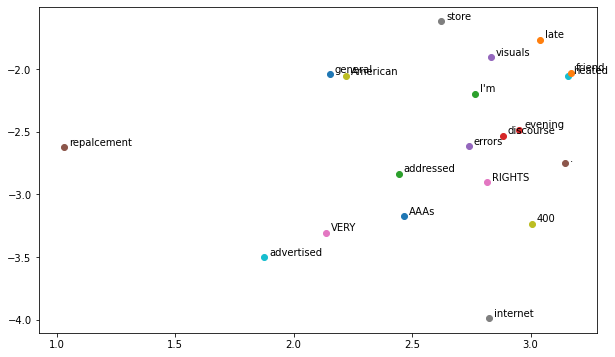

In [36]:
plt.figure(figsize=(10,6))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed_normal(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

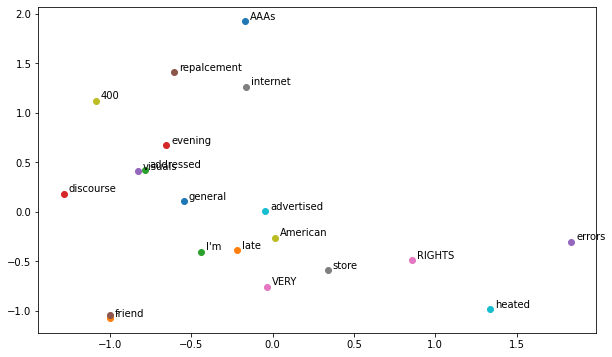

In [37]:
plt.figure(figsize=(10,6))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed_negative(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## Similarity test

In [38]:
# def cos_sim(a, b):
#     cos_sim = dot(a, b)/(norm(a)*norm(b))
#     return cos_sim

In [39]:
cos_sim = lambda a,b : dot(a, b)/(norm(a)*norm(b))

In [40]:
def test_senario_Negative(a1 , a2) :
    tester1 = get_embed_negative(a1)
    teater2 = get_embed_negative(a2)
    print(f"{a1} similarity to {a2} = {cos_sim(tester1 , teater2)}")

In [41]:
def test_senario_normal(a1 , a2) :
    tester1 = get_embed_normal(a1)
    teater2 = get_embed_normal(a2)
    print(f"{a1} similarity to {a2} = {cos_sim(tester1 , teater2)}")

In [42]:
test_senario_Negative("Japan","English")
test_senario_Negative("price","price")
test_senario_Negative("spectacular","Amazing")

Japan similarity to English = 0.7606008047594415
price similarity to price = 0.9999999999999998
spectacular similarity to Amazing = 0.6806616699561909


In [44]:
test_senario_normal("Japan","English")
test_senario_normal("price","Japan")
test_senario_normal("Awful","want") 

Japan similarity to English = 0.9997727428707145
price similarity to Japan = 0.9554230264897314
Awful similarity to want = 0.9957233525923458
